In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import root_mean_squared_error, r2_score

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import math
from scipy.stats import skew

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
PATH_TRAIN = r"datasets\train.csv"
PATH_TEST = r"datasets\test.csv"

In [3]:
df_train = pd.read_csv(PATH_TRAIN)
df_test = pd.read_csv(PATH_TEST)

In [4]:
print("Shape Train:", df_train.shape)
print("Shape Test:", df_test.shape)

Shape Train: (1460, 81)
Shape Test: (1459, 80)


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
df_train.dropna(subset=['Electrical'], inplace=True)

In [8]:
DROPPED_COL = ["Utilities", "PoolArea", "CentralAir", "PoolQC"]
X = df_train.drop(["SalePrice", "Id", *DROPPED_COL], axis=1)
y = df_train["SalePrice"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [10]:
nulls = X_train.isna().sum()[lambda x: x > 0].sort_values(ascending=False)
nulls

MiscFeature     984
Alley           949
Fence           817
MasVnrType      613
FireplaceQu     488
LotFrontage     192
GarageType       53
GarageYrBlt      53
GarageFinish     53
GarageCond       53
GarageQual       53
BsmtCond         29
BsmtFinType2     29
BsmtExposure     29
BsmtQual         29
BsmtFinType1     29
MasVnrArea        5
dtype: int64

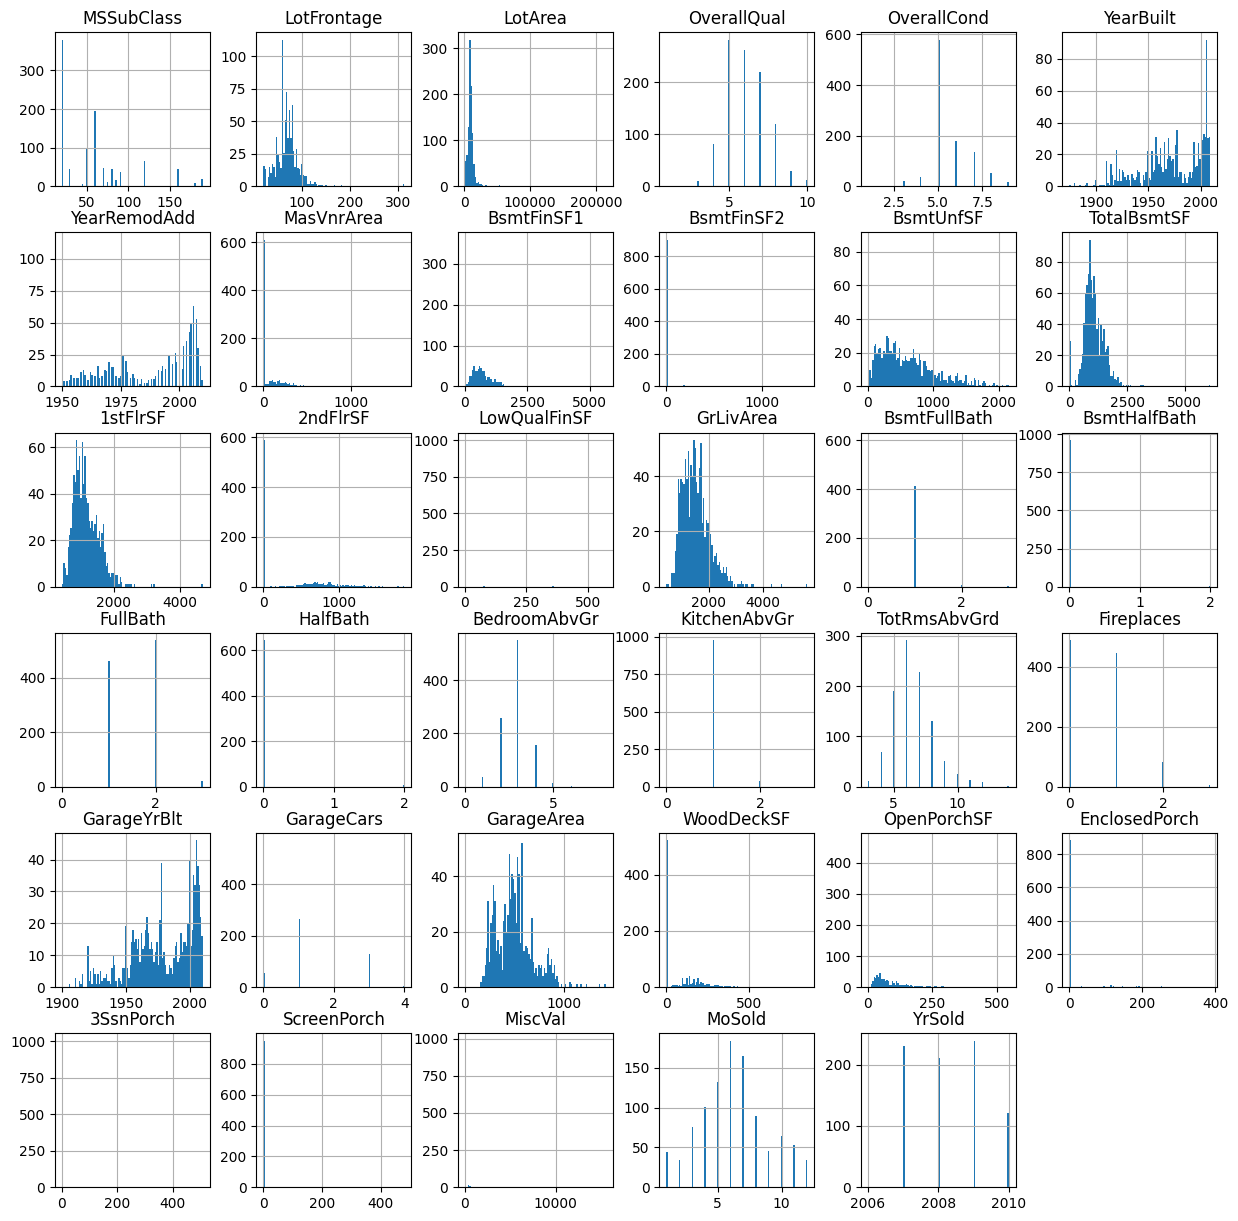

In [11]:
_ = X_train.hist(figsize=(15, 15), bins=100)

Handel Null Values

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin


class GroupMedianImputer(BaseEstimator, TransformerMixin):
    def __init__(self, group_col, target_col):
        self.group_col = group_col
        self.target_col = target_col

    def fit(self, X, y=None):
        self.median_values = X.groupby(self.group_col)[
            self.target_col].median()
        self.global_median_ = X[self.target_col].median()
        return self

    def transform(self, X):
        df = X.copy()
        df[self.target_col] = df[self.target_col].fillna(
            df[self.group_col].map(self.median_values))
        df[self.target_col] = df[self.target_col].fillna(self.global_median_)
        return df

In [13]:
nulls = X_train.isna().sum()[lambda x: x > 0].sort_values(ascending=False)
nulls

MiscFeature     984
Alley           949
Fence           817
MasVnrType      613
FireplaceQu     488
LotFrontage     192
GarageType       53
GarageYrBlt      53
GarageFinish     53
GarageCond       53
GarageQual       53
BsmtCond         29
BsmtFinType2     29
BsmtExposure     29
BsmtQual         29
BsmtFinType1     29
MasVnrArea        5
dtype: int64

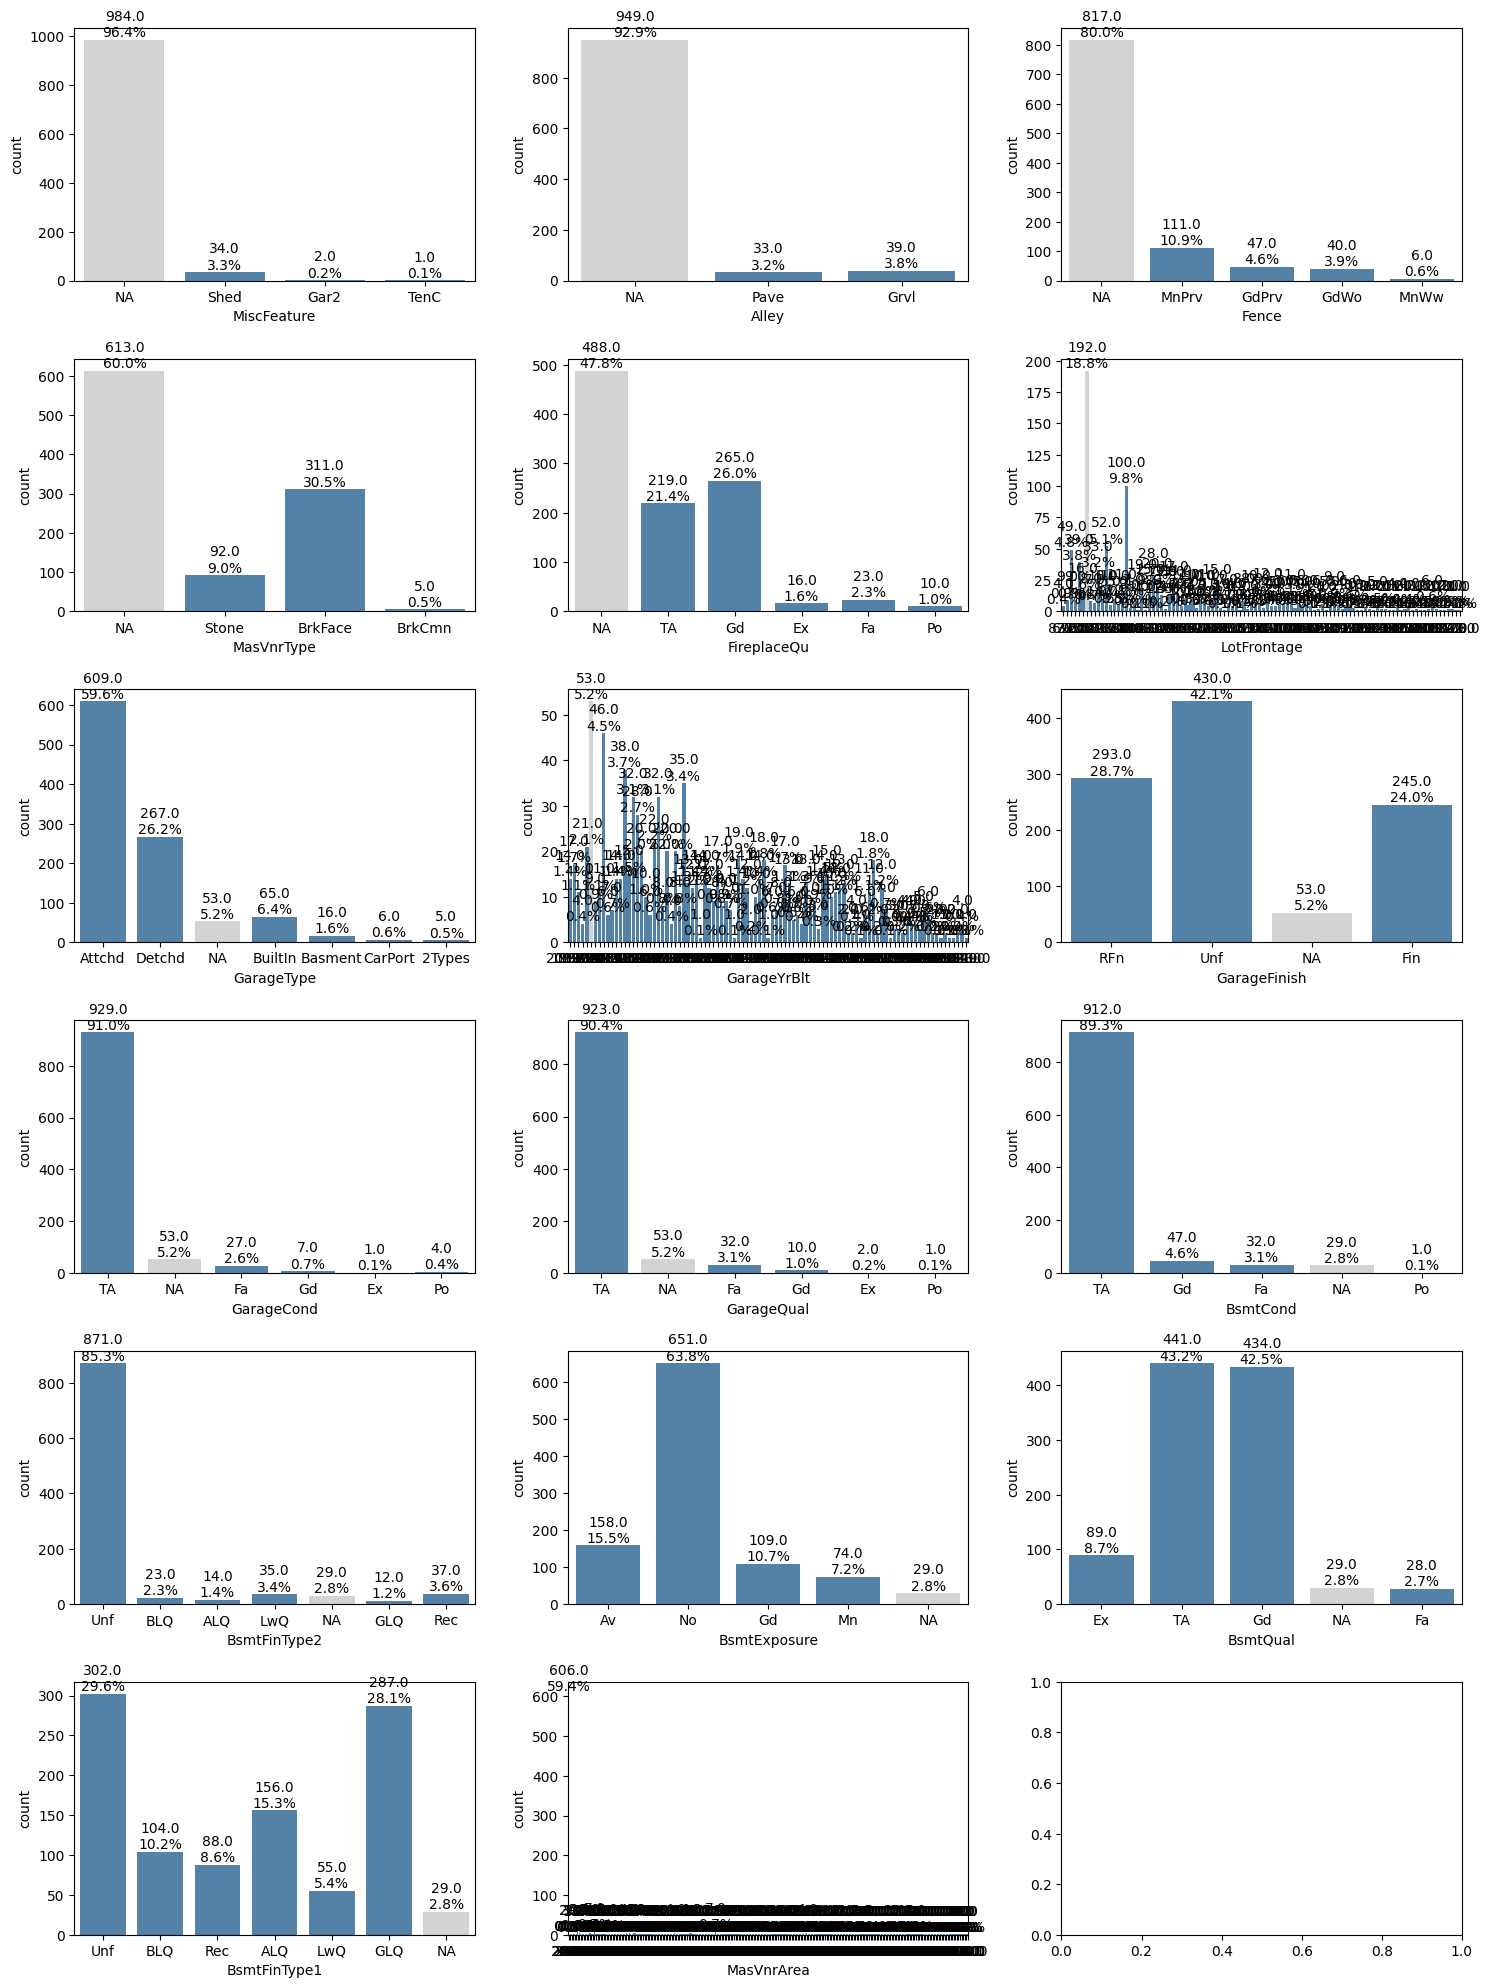

In [14]:
ncols = 3
m = X_train.shape[0]

fig, axs = plt.subplots(math.ceil(len(nulls)/ncols), ncols, figsize=(15, 20))

axs = axs.ravel()


def color(coln):
    return 'lightgray' if pd.isna(coln) else 'steelblue'


for i, nulls_col in enumerate(nulls.index):
    value_count = X_train[nulls_col].value_counts(dropna=False, normalize=True)
    colors = [color(col) for col in X_train[nulls_col].unique()]
    sns.countplot(
        ax=axs[i], x=X_train[nulls_col].fillna('NA'), palette=colors,)

    for c in axs[i].containers:
        axs[i].bar_label(
            c, fmt=lambda v: f'{v}\n{(v/m)*100:0.1f}%')

fig.tight_layout()

In [15]:
NA_col = ["TotalBsmtSF", "GarageArea", "MiscFeature",
          "Alley", "Fence", "MasVnrType", "FireplaceQu"]
has_NA_col = [f"Has{col}" for col in NA_col]
X_train[has_NA_col[:2]] = X_train[NA_col[:2]] != 0
X_train[has_NA_col[2:]] = X_train[NA_col[2:]].notna()
# X_train[zero_col] = X_train[zero_col].fillna(0)


gmi = GroupMedianImputer("Neighborhood", "LotFrontage")
X_train = gmi.fit_transform(X_train)

Ordinal Encoding & Binomial Encoding

In [16]:
ORDINAL_MAPS = {

    'Typ': 8,
    'Min1': 7,
    'Min2': 6,
    'Mod': 5,
    'Maj1': 4,
    'Maj2': 3,
    'Sev': 2,
    'Sal': 1,

    'GLQ': 6,
    'ALQ': 5,
    'BLQ': 4,
    'Rec': 3,
    'LwQ': 2,
    'Unf': 1,

    "SBrkr": 5,
    "FuseA": 4,
    "FuseF": 3,
    "Mix": 2,
    "FuseP": 1,

    'Ex': 5,
    'Gd': 4,
    'TA': 3,
    'Fa': 2,
    'Po': 1,

    'GdPrv': 4,
    'MnPrv': 3,
    'GdWo': 2,
    'MnWw': 1,

    "Reg": 4,
    "IR1": 3,
    "IR2": 2,
    "IR3": 1,

    "Lvl": 4,
    "Bnk": 3,
    "HLS": 2,
    "Low": 1,

    # "AllPub": 4,
    # "NoSewr": 3,
    # "NoSeWa": 2,
    # "ELO": 1,

    'Av': 3,
    'Mn': 2,
    'No': 1,

    'Fin': 3,
    'RFn': 2,
    'Unf': 1,

    'Gtl': 3,
    'Mod': 2,
    'Sev': 1,

    'Y': 2,
    'P': 1,
    'N': 0,

    "Pave": 1,
    "Grvl": 0,

}

X_train = X_train.map(lambda x: ORDINAL_MAPS.get(x, x))

Handel Zero-Inflated

In [17]:
# zero_inflated_col = ["MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "2ndFlrSF", "LowQualFinSF", "BsmtFullBath", "BsmtHalfBath",
#                      "HalfBath", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "MiscVal",]
# for col in zero_inflated_col:
#     if X_train[col].value_counts().index[0] == 0:
#         X_train["Z_" + col] = X_train[col] > 0

Multicollinearity & Correlation

<Axes: >

Error in callback <function _draw_all_if_interactive at 0x000001DF814551C0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

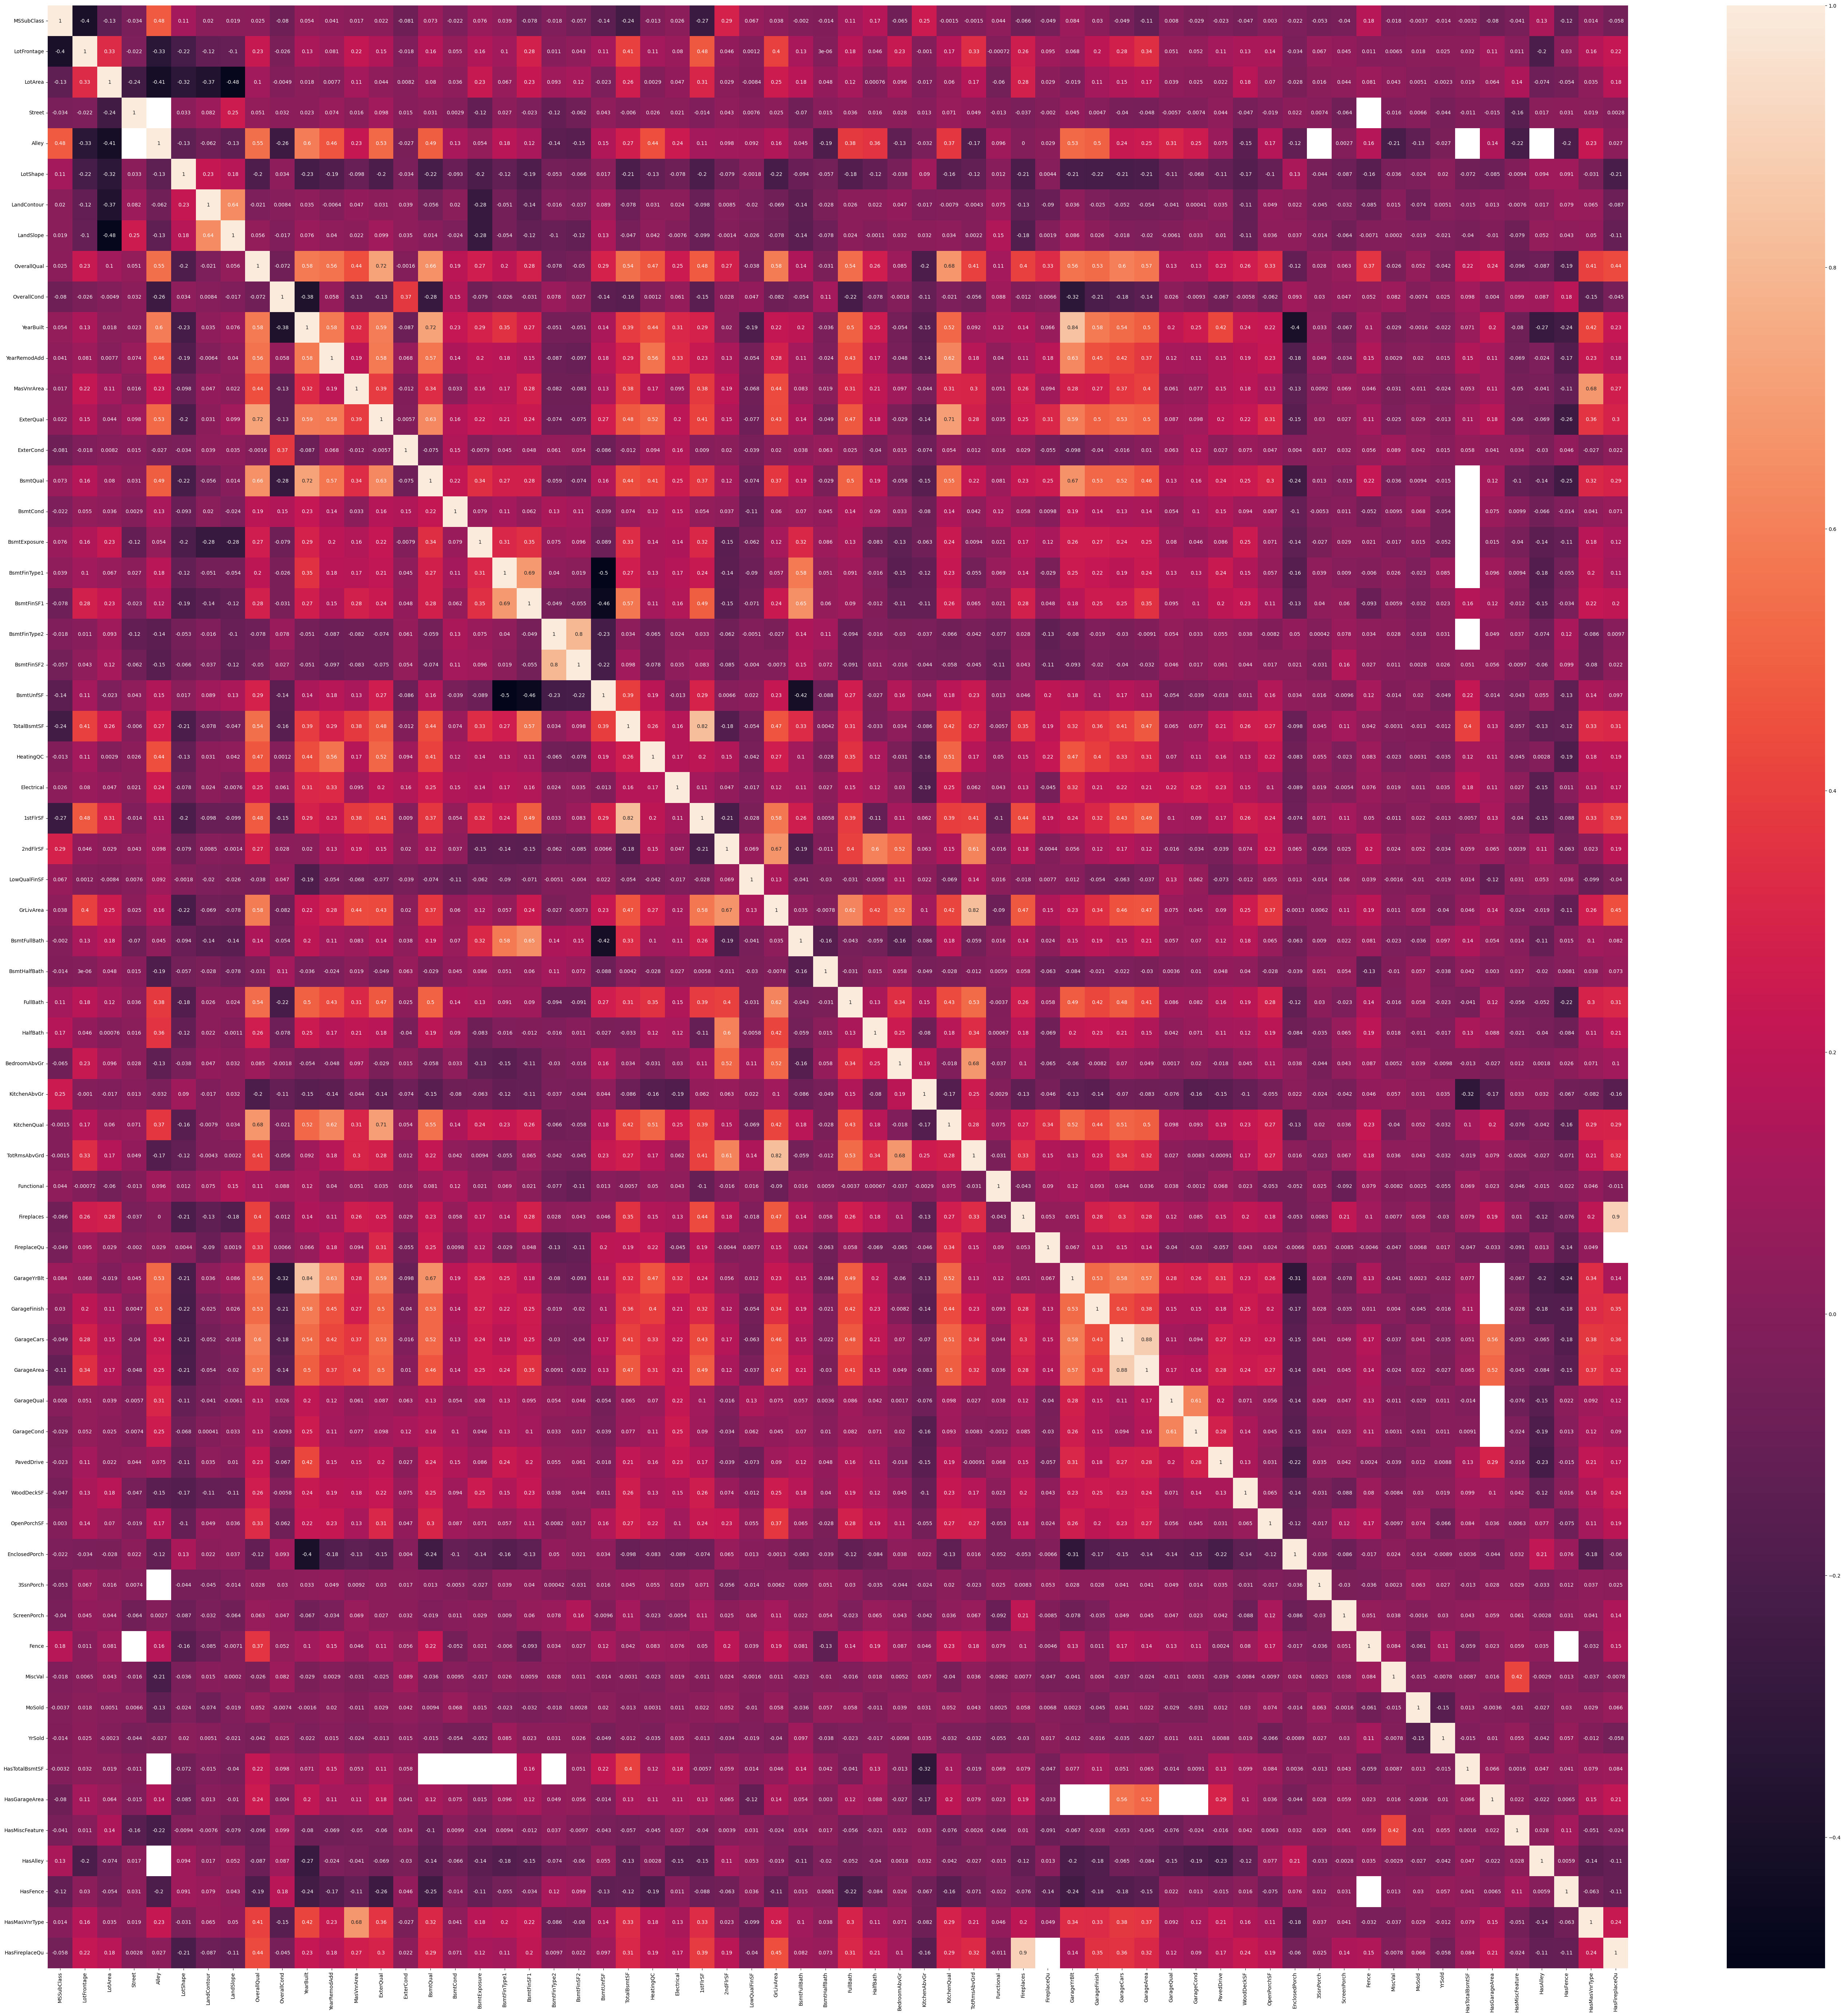

In [18]:
plt.figure(figsize=(70, 70))
sns.heatmap(X_train.corr(numeric_only=True), annot=True)

Handel Skewness

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import PowerTransformer, QuantileTransformer
# cols1 = X_train.select_dtypes("number").columns


# def test_transformers(columns, X_train, n_quantiles=500):
#     pt = PowerTransformer()
#     qt = QuantileTransformer(n_quantiles=n_quantiles,
#                              output_distribution='normal')

#     for col in columns:

#         # fig, axs = plt.subplots(1, 3, figsize=(15, 5))
#         array = np.array(X_train[col]).reshape(-1, 1)
#         pt_array = pt.fit_transform(array)
#         qt_array = qt.fit_transform(array)
#         skew_transformed_option = [array, pt_array, qt_array]
#         # sns.histplot(array, ax=axs[0], bins=50, kde=True)
#         # axs[0].set_title(f"OD {i} {skew(array)}")

#         # sns.histplot(x, ax=axs[1], bins=50, kde=True)
#         # axs[1].set_title(f"QT {i} {skew(x)}")

#         # sns.histplot(y, ax=axs[2], bins=50, kde=True)
#         # axs[2].set_title(f"PT {i} {skew(y)}")

#         idxmin = np.argmin(
#             list(map(lambda x: np.abs(skew(x)), skew_transformed_option)))
#         X_train[col] = skew_transformed_option[idxmin]

#     # fig.tight_layout()


# test_transformers(cols1, X_train)

In [ ]:
# from sklearn.preprocessing import PowerTransformer, QuantileTransformer
# qt = QuantileTransformer(n_quantiles=500, output_distribution='normal')
# pt = PowerTransformer()

# sns.histplot(qt.inverse_transform(
#     qt.fit_transform(np.array(y_train).reshape(-1, 1))))

Handel Categorical

In [19]:
categorical_columns = X_train.select_dtypes("object").columns
numerical_columns = X_train.select_dtypes("number").columns

In [20]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
one_hot_encoded = encoder.fit_transform(X_train[categorical_columns])

one_hot_X_train = pd.DataFrame(
    one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))


X_train_encoded = pd.concat([X_train.reset_index(
    drop=True), one_hot_X_train.reset_index(drop=True)], axis=1)

X_train_encoded = X_train_encoded.drop(categorical_columns, axis=1)

Train Model

In [ ]:
rfr = RandomForestRegressor()
rfr.fit(X_train_encoded, y_train)
feature_importances = pd.DataFrame(rfr.feature_importances_.round(4),
                                   index=X_train_encoded.columns, columns=["importances"]).sort_values("importances", ascending=False)


KeyError: 'MiscFeature'

In [ ]:
feature_importances.T

["MiscFeature"]

,OverallQual,GrLivArea,TotalBsmtSF,BsmtFinSF1,2ndFlrSF,1stFlrSF,GarageArea,MasVnrArea,LotArea,GarageCars,...,SaleType_CWD,MiscFeature_nan,SaleType_ConLw,SaleType_ConLI,SaleType_ConLD,SaleType_Con,SaleType_COD,SaleType_Oth,SaleCondition_AdjLand,SaleCondition_Alloca
importances,0.59,0.115,0.0382,0.0305,0.0274,0.021,0.0144,0.0137,0.0125,0.008,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Prepare X_test

In [ ]:
Id_test = df_test["Id"]
df_test = df_test.drop(["Id",*DROPPED_COL], axis=1)

In [41]:
df_test.isna().sum()[lambda x: x > 0].sort_values(ascending=False)

df_train["MiscFeature"].value_counts()

MiscFeature
Shed    49
Gar2     2
Othr     2
TenC     1
Name: count, dtype: int64

In [23]:
NA_col = ["TotalBsmtSF", "GarageArea", "MiscFeature",
          "Alley", "Fence", "MasVnrType", "FireplaceQu"]
has_NA_col = [f"Has{col}" for col in NA_col]
X_test[has_NA_col[:2]] = X_test[NA_col[:2]] != 0
X_test[has_NA_col[2:]] = X_test[NA_col[2:]].notna()

X_test = gmi.transform(X_test)

In [24]:
X_test = X_test.map(lambda x: ORDINAL_MAPS.get(x, x))

In [25]:
one_hot_encoded = encoder.transform(X_test[categorical_columns])

one_hot_X_test = pd.DataFrame(
    one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))


X_test_encoded = pd.concat([X_test.reset_index(
    drop=True), one_hot_X_test.reset_index(drop=True)], axis=1)

X_test_encoded = X_test_encoded.drop(categorical_columns, axis=1)

In [26]:
lr = LinearRegression()
lr.fit(X_train_encoded, y_train)

y_hat = lr.predict(X_train_encoded)

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
best_feature = list(X_train_encoded.columns)
best_value = 0.822041855207573
for _ in range(X_train.shape[1]):
    removed_col = best_feature.pop()
    r2_score = cross_val_score(
        rfr, X_train_encoded[best_feature], y_train, scoring='r2')

    adj_r2 = 1 - (1-r2_score.mean()) * (len(y_train)-1) / \
        (len(y_train)-X_train.shape[1]-1)

    if best_value < adj_r2:
        best_value = adj_r2
        print(len(best_feature), best_value)
    else:
        best_feature.insert(0, removed_col)

best_feature

In [ ]:
y_hat = rfr.predict(X_test_encoded)

root_mean_squared_error(y_test, y_hat)

In [ ]:
# rfr.fit(X_train.select_dtypes('number'), y_train)
# root_mean_squared_error(rfr.predict(X_test.select_dtypes('number')), y_test)
# ================================
# p_grid = {'max_depth': [None]}
# inner_cv = KFold(n_splits=4, shuffle=True)
# outer_cv = KFold(n_splits=4, shuffle=True)
# clf = GridSearchCV(estimator=rfr, param_grid=p_grid, cv=inner_cv)
# nested_score = cross_val_score(
#     clf, X=X.select_dtypes('number'), y=y, scoring='neg_root_mean_squared_error', cv=outer_cv)
# nested_score.mean()